# 1. Import necessary packages and data

In [1]:
# packages for working with the data
import numpy as np
import pandas as pd

#packages for visualization and EDA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# geodataframes
import geopandas as gpd

# visualization of spatial data
import geoplot
import geoplot.crs as gcrs

In [3]:
# training data
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')

# observations to predict the labels
to_predict = pd.read_csv('to_predict.csv')

# format / pattern for the submission of predictet labels
submission_format = pd.read_csv('SubmissionFormat.csv')

In [4]:
# merge training features and labels
train = train_features.merge(train_labels, how='left', on='id')

In [5]:
train.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


In [6]:
to_predict.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other


Since we are given the longitudes and latitudes of the wells in these dataframes, we should convert them to geodataframes such that we can analyze the functionality of the wells in dependence of their spatial features.

In [7]:
# transform dataframes to geodataframes
train = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.longitude, train.latitude))
to_predict = gpd.GeoDataFrame(to_predict, geometry=gpd.points_from_xy(to_predict.longitude, to_predict.latitude))

In [8]:
# get information about data types and missing values
train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 42 columns):
id                       59400 non-null int64
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null 

## 1.1 Target variable 'status_group'

In [9]:
train['status_group'].unique()
# 3 ordinal values for ' status_group'

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

The target variabel has three distinct values, which indicate the condition of the well. These three values are actually ordinal: 1, if functional; 0, if not functional; 0.5, if functional but needs a repair.

Especially for feature engineering this numerical mapping of the values is very useful and is thus going to be applied.

Also I am going to have a quick look at the distribution of these three values in the training dataset.

In [10]:
# create numerical equivalent to target variable for feature engineering
mapping = {'functional':1, 'functional needs repair':0.5, 'non functional':0}
train['status_group_numeric'] = train['status_group'].map(mapping)

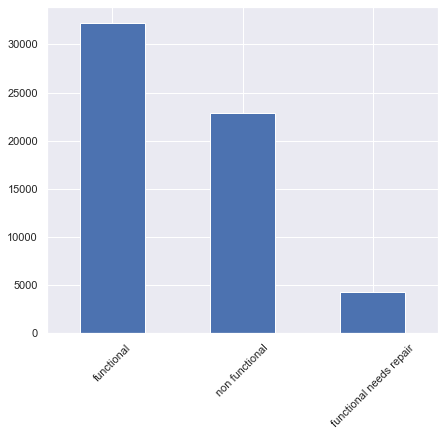

In [11]:
# distribution of the values in the training data
sns.set()

train['status_group'].value_counts().plot(kind='bar', figsize=(7, 6), rot=45)

plt.show()

# 2. Exploratory data analysis & some cleansing

There are tons of features in this dataset, which however can be grouped and summarized. I have identified the following six groups of features:



*   Geographic / spatial features
*   temporal features
*   management / ownership features
*   individual features about the wells and the water
*   demographic, social and economic features
*   other / remaining features


I am going to work on each of these groups in subsequent steps.



## 2.1 Other / remaining features

### 2.1.1 'recorded_by'

In [12]:
print(train['recorded_by'].unique())
print(to_predict['recorded_by'].unique())

['GeoData Consultants Ltd']
['GeoData Consultants Ltd']


The feature 'recorded_by' is the same for each observation, which means that there is no useful information in that feature. Thus, we can drop it.

In [13]:
# drop column 'recorded_by'
train.drop(['recorded_by'], axis=1, inplace=True)
to_predict.drop(['recorded_by'], axis=1, inplace=True)

### 2.1.2 'num_private'

There is no real documentation that tells us, what this feature is about. Because of that we are going to do some EDA on that to look, if this feature might be useful

In [14]:
train['num_private'].unique()

array([   0,   39,    5,   45,    6,    3,  698,   32,   15,    7,   25,
        102,    1,   93,   14,   34,  120,   17,  213,   47,    8,   41,
         80,  141,   20,   35,  131,    4,   22,   11,   87,   61,   65,
        136,    2,  180,   38,   62,    9,   16,   23,   42,   24,   12,
        668,  672,   58,  150,  280,  160,   50, 1776,   30,   27,   10,
         94,   26,  450,  240,  755,   60,  111,  300,   55, 1402],
      dtype=int64)

In [15]:
train['num_private'].value_counts(normalize=True)

0      0.987256
6      0.001364
1      0.001229
5      0.000774
8      0.000774
         ...   
180    0.000017
213    0.000017
23     0.000017
55     0.000017
94     0.000017
Name: num_private, Length: 65, dtype: float64

There are a lot of issues with this feature:
1. We don't know at all what this feature tells us
2. Almost all observations have the value 0 there, so we can't really infer any information from this feature.

Becaus of these issues I am going to drop this column.

In [16]:
# drop feature 'num_private'
train.drop(['num_private'], axis=1, inplace=True)
to_predict.drop(['num_private'], axis=1, inplace=True)

## 2.2 Demographic, social and economic features

### 2.2.1 Population

According to the documentation this feature is the "Population around the well". There is no further specification or explanation about this feature.

There are no missing values for this feature.

In [17]:
# get overview of range and distribution of 'population'
train['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [18]:
# eda on relationship between population and status of the wells
train.groupby('status_group')['population'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,187.553303,513.198991,0.0,0.0,40.0,200.0,30500.0
functional needs repair,4317.0,175.102154,433.033756,0.0,0.0,25.0,245.0,15300.0
non functional,22824.0,170.016430,413.094978,0.0,0.0,1.0,230.0,9865.0


There is a little effect of 'population' on 'status_group':

The larger the population, the more likely the well is in a good / functioning condition.

### 2.2.2 'public_meeting'

In [19]:
train['public_meeting'].unique()

array([True, nan, False], dtype=object)

There are missing values

In [20]:
# convert data type of 'public_meetin' to float
train['public_meeting'] = train['public_meeting'].astype('float')
to_predict['public_meeting'] = to_predict['public_meeting'].astype('float')

In [21]:
# exploratory analysis on the effect of 'public_meeting' on 'status_group'
train.groupby('status_group')['public_meeting'].mean()

status_group
functional                 0.928943
functional needs repair    0.893776
non functional             0.885575
Name: public_meeting, dtype: float64

In [22]:
# explore difference in "average functionality"
train.groupby('public_meeting')['status_group_numeric'].mean()

public_meeting
0.0    0.473591
1.0    0.593352
Name: status_group_numeric, dtype: float64

In [23]:
# more detailed exploration
pd.crosstab(train['public_meeting'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
public_meeting,,,
0.0,0.429871,0.087438,0.482690
1.0,0.556899,0.072906,0.370195


In [24]:
# exploratory analysis on the role of missing features in 'public_meeting'
train[train['public_meeting'].isnull()]['status_group_numeric'].mean()

0.5266946610677864

In [25]:
train[train['public_meeting'].isnull()]['status_group'].value_counts(normalize=True)

functional                 0.503299
non functional             0.449910
functional needs repair    0.046791
Name: status_group, dtype: float64

We don't really know what exactly 'public_meeting' is supposed to mean. However, we could observe a little effect of it on 'status_group'. Also, if there are missing values, there seems to be a higher chance, that the well is not functioning.

### 2.2.3 'permit'

This feature tells us, if the well is permitted, i.e. if it is legal.

In [26]:
train['permit'].unique()

array([False, True, nan], dtype=object)

There are some missing values here as well.

In [27]:
train['permit'].value_counts(normalize=True)

True     0.68955
False    0.31045
Name: permit, dtype: float64

In [28]:
# convert to numeric format
train['permit'] = train['permit'].astype('float')
to_predict['permit'] = to_predict['permit'].astype('float')

In [29]:
train.groupby('status_group')['permit'].mean()

status_group
functional                 0.704276
functional needs repair    0.671397
non functional             0.672186
Name: permit, dtype: float64

In [30]:
pd.crosstab(train['permit'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
permit,,,
0.0,0.517094,0.075463,0.407443
1.0,0.554437,0.069417,0.376145


In [31]:
train.groupby('permit')['status_group_numeric'].mean()

permit
0.0    0.554825
1.0    0.589146
Name: status_group_numeric, dtype: float64

In [32]:
train[train['permit'].isnull()]['status_group_numeric'].mean()

0.5965314136125655

In [33]:
train[train['permit'].isnull()]['status_group'].value_counts(normalize=True)

functional                 0.547448
non functional             0.354385
functional needs repair    0.098168
Name: status_group, dtype: float64

## 2.3 Temporal features

### 2.3.1 'date_recorded'

Maybe the time dimension has an effect on the condition of the wells as well due to seasonal weather conditions.

In [34]:
# convert 'date_recorded' to datetime objects
train['date_recorded'] = pd.to_datetime(train['date_recorded'])
to_predict['date_recorded'] = pd.to_datetime(to_predict['date_recorded'])

In [35]:
# extract month in which the well has been observede / recorded
train['month_recorded'] = train['date_recorded'].dt.month
to_predict['month_recorded'] = to_predict['date_recorded'].dt.month

In [36]:
# create crosstab with counts of observed statuses with months as indices
wells_month = pd.crosstab(train['month_recorded'], train['status_group'])

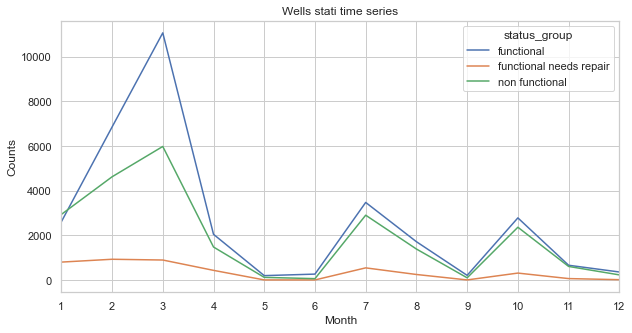

In [37]:
sns.set_style('whitegrid')

wells_month.plot(figsize=(10, 5))

plt.xlabel('Month')
plt.ylabel('Counts')
plt.title('Wells stati time series')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
plt.grid(True)

plt.show()

In [38]:
# check if the spike in March is due to general distribution
train['month_recorded'].value_counts(normalize=True)

3     0.301953
2     0.208788
7     0.116633
1     0.106970
10    0.092020
4     0.066835
8     0.056633
11    0.022710
12    0.010455
6     0.005825
5     0.005657
9     0.005522
Name: month_recorded, dtype: float64

The time / month feature does not seem to give us useful information in general. That is because this feature rather shows us, when the government has been examining the wells a lot, i.e. the distribution of the months is very unequal.

### 2.3.2 'construction_year'

There are no 'official' missing values in 'construction_year'

In [39]:
train['construction_year'].unique()

array([1999, 2010, 2009, 1986,    0, 2011, 1987, 1991, 1978, 1992, 2008,
       1974, 2000, 2002, 2004, 1972, 2003, 1980, 2007, 1973, 1985, 1970,
       1995, 2006, 1962, 2005, 1997, 2012, 1996, 1977, 1983, 1984, 1990,
       1982, 1976, 1988, 1989, 1975, 1960, 1961, 1998, 1963, 1971, 1994,
       1968, 1993, 2001, 1979, 1967, 2013, 1969, 1981, 1964, 1966, 1965],
      dtype=int64)

In [40]:
to_predict['construction_year'].unique()

array([2012, 2000, 2010, 1987, 1990, 2007, 1982, 1997, 2003, 2006, 2002,
          0, 1984, 1989, 1978, 2008, 2005, 1970, 2009, 1998, 1971, 1972,
       1983, 1974, 1992, 1999, 2004, 2011, 1988, 1962, 1986, 1985, 1969,
       1996, 1994, 1960, 1975, 1981, 1995, 1963, 1977, 2001, 1993, 1991,
       1976, 1980, 2013, 1979, 1967, 1973, 1968, 1965, 1961, 1966, 1964],
      dtype=int64)

In [41]:
print(len(train[train['construction_year'] == 0]))
print(len(to_predict[to_predict['construction_year'] == 0]))

20709
5260


However, the value 0 for 'construction_year' seems to indicate missing values.

In [42]:
# replace 0 with missing values
train['construction_year'].replace(0, np.nan, inplace=True)
to_predict['construction_year'].replace(0, np.nan, inplace=True)

Now we can calculate the age of each well

In [43]:
# create a variable with today's date / year
current_year = 2020

In [44]:
# calculate age of wells
train['waterpoint_age'] = current_year - train['construction_year']
to_predict['waterpoint_age'] = current_year - to_predict['construction_year']

In [45]:
train.groupby('status_group')['waterpoint_age'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,21704.0,20.061325,10.931700,7.0,11.0,17.0,25.0,60.0
functional needs repair,2528.0,24.742089,12.533262,7.0,14.0,22.0,35.0,60.0
non functional,14459.0,27.602462,13.222473,7.0,16.0,26.0,39.0,60.0


In [46]:
train[train['waterpoint_age'].isnull()]['status_group'].value_counts(normalize=True)

functional                 0.509682
non functional             0.403931
functional needs repair    0.086388
Name: status_group, dtype: float64

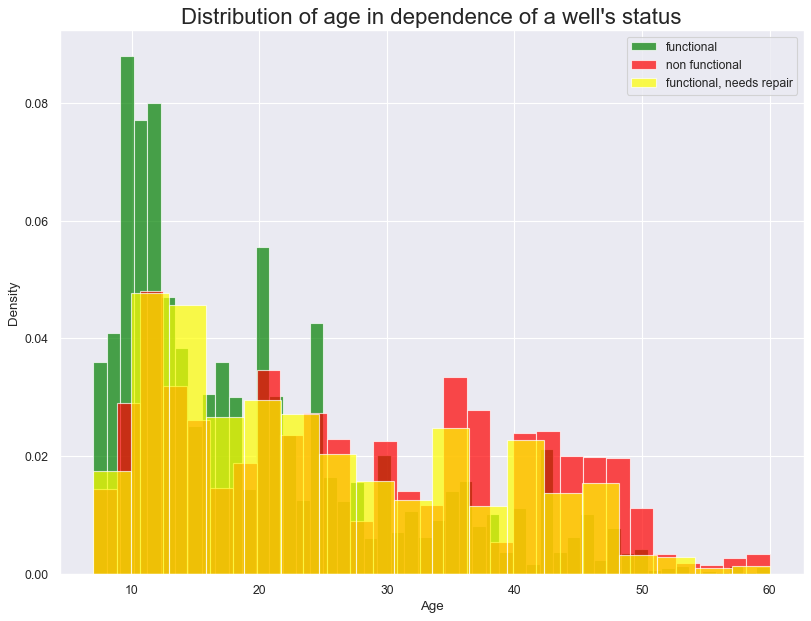

In [47]:
sns.set()
plt.figure(figsize=(12,9), dpi= 80)

sns.distplot(train.loc[train['status_group']=='functional', 'waterpoint_age'].dropna(), kde=False, norm_hist=True,
             color='green',hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, label="functional")
sns.distplot(train.loc[train['status_group']=='non functional', 'waterpoint_age'].dropna(), kde=False, norm_hist=True,
             color='red',hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, label="non functional")
sns.distplot(train.loc[train['status_group']=='functional needs repair', 'waterpoint_age'].dropna(), kde=False, norm_hist=True,
             color='yellow',hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, label="functional, needs repair")

plt.legend()
plt.xlabel('Age')
plt.ylabel('Density')
plt.title("Distribution of age in dependence of a well's status", fontsize=20)

plt.show()

## 2.4 Management / ownership features

### 2.4.1 'scheme_management' / 'management' / 'management_group'

"Who operates the waterpoint" / "How the waterpoint is managed"

There are missing values.

In [48]:
print(train['scheme_management'].unique())
print(len(train['scheme_management'].unique()))

['VWC' 'Other' nan 'Private operator' 'WUG' 'Water Board' 'WUA'
 'Water authority' 'Company' 'Parastatal' 'Trust' 'SWC' 'None']
13


In [49]:
print(train['management'].unique())
print(len(train['management'].unique()))

['vwc' 'wug' 'other' 'private operator' 'water board' 'wua' 'company'
 'water authority' 'parastatal' 'unknown' 'other - school' 'trust']
12


In [50]:
print(train['management_group'].unique())
print(len(train['management_group'].unique()))

['user-group' 'other' 'commercial' 'parastatal' 'unknown']
5


In [51]:
train['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [52]:
train['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [53]:
train['management'].isnull().sum()

0

Since the column 'management' has no missing values and the size and number of the different groups is reasonable, I am going to use this column for our analysis and drop the other two.

In [54]:
# drop columns 'scheme_management'
train.drop(['scheme_management'], axis=1, inplace=True)
to_predict.drop(['scheme_management'], axis=1, inplace=True)

EDA on 'management'

In [55]:
train.groupby('management')['status_group_numeric'].mean()

management
company             0.400730
other               0.630924
other - school      0.237374
parastatal          0.636595
private operator    0.760020
trust               0.628205
unknown             0.423351
vwc                 0.538685
water authority     0.522124
water board         0.785032
wua                 0.731164
wug                 0.649041
Name: status_group_numeric, dtype: float64

In [56]:
pd.crosstab(train['management'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
management,,,
company,0.389781,0.021898,0.588321
other,0.598341,0.065166,0.336493
other - school,0.232323,0.010101,0.757576
parastatal,0.576923,0.119344,0.303733
private operator,0.748858,0.022324,0.228818
trust,0.589744,0.076923,0.333333
unknown,0.399287,0.048128,0.552585
vwc,0.504234,0.068902,0.426864
water authority,0.493363,0.057522,0.449115


### 2.4.2 'scheme_name'

"Who operates the waterpoint"

Lots of missing values

In [57]:
print(train['scheme_name'].unique())
print(len(train['scheme_name'].unique()))

['Roman' nan 'Nyumba ya mungu pipe scheme' ... 'BL Nsherehehe'
 'Magati  gravity spri' 'Mtawanya']
2697


We can't really infer any useful information from that column for our potential ML model.
Still I am not going to drop this column since I can't know if it might still give us useful information for our (exploratory) analysis.

### 2.4.3 'payment' / 'payment_type'

In [58]:
print(train['payment'].unique())
print(len(train['payment'].unique()))

['pay annually' 'never pay' 'pay per bucket' 'unknown'
 'pay when scheme fails' 'other' 'pay monthly']
7


In [59]:
print(train['payment_type'].unique())
print(len(train['payment_type'].unique()))

['annually' 'never pay' 'per bucket' 'unknown' 'on failure' 'other'
 'monthly']
7


This feature tells us with which payment system the well operates. However, we have two features which tell us the same things.
Thus, we can drop one of these columns.

In [60]:
# drop column 'payment'
train.drop(['payment'], axis=1, inplace=True)
to_predict.drop(['payment'], axis=1, inplace=True)

In [61]:
train.groupby('payment_type')['status_group_numeric'].mean()

payment_type
annually      0.786244
monthly       0.716325
never pay     0.486528
on failure    0.655979
other         0.635674
per bucket    0.700556
unknown       0.458992
Name: status_group_numeric, dtype: float64

In [62]:
pd.crosstab(train['payment_type'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
payment_type,,,
annually,0.752334,0.067820,0.179846
monthly,0.660482,0.111687,0.227831
never pay,0.448911,0.075233,0.475856
on failure,0.620593,0.070772,0.308636
other,0.579696,0.111954,0.308349
per bucket,0.677796,0.045520,0.276683
unknown,0.432512,0.052961,0.514527


### 2.4.4 'funder' and 'installer'

These two features might be closely related to each other. 'funder' tells us who (which country, NGO, company,...) financed the well. 'installer' on the other hand tells who operated the building of the well.

In [63]:
print(train['funder'].unique())
print(len(train['funder'].unique()))

['Roman' 'Grumeti' 'Lottery Club' ... 'Dina' 'Brown' 'Samlo']
1898


In [64]:
print(train['installer'].unique())
print(len(train['installer'].unique()))

['Roman' 'GRUMETI' 'World vision' ... 'Dina' 'brown' 'SELEPTA']
2146


A lot of values for these features. Maybe some values are duplicate due to different spelling.
We can fix that by turning all strings to uppercase.

In [65]:
# convert values for 'funder' to uppercase
train['funder'] = train['funder'].str.upper()
to_predict['funder'] = to_predict['funder'].str.upper()

# convert values for 'installer' to uppercase
train['installer'] = train['installer'].str.upper()
to_predict['installer'] = to_predict['installer'].str.upper()

Let's see if there are fewer values now.

In [66]:
print(train['funder'].unique())
print(len(train['funder'].unique()))

['ROMAN' 'GRUMETI' 'LOTTERY CLUB' ... 'DINA' 'BROWN' 'SAMLO']
1898


In [67]:
print(train['installer'].unique())
print(len(train['installer'].unique()))

['ROMAN' 'GRUMETI' 'WORLD VISION' ... 'DINA' 'BROWN' 'SELEPTA']
1936


In [68]:
train['installer'].value_counts().sort_values().head(10)

KAGULO                      1
MARUMBO COMMUNITY           1
EMMANUEL KITAPONDA          1
CIDA                        1
ISF AND TACARE              1
VILLAGE COUNCIL .ODA        1
MWAMVITA RAJABU             1
DISTRICT COMMUNITY J        1
GOVERNMENT /WORLD VISION    1
NDM                         1
Name: installer, dtype: int64

'funder' and 'installer' have about the same number of different values, so they should give us similar information.
I consider 'installer' to be slighty more relevant, because this feature is more closely related to the operation of building the wells and thus has a more direct impact on the status of the wells.
One problem with this / these features is however that a lot of its values only occured once or very few times in this dataset.

In [69]:
train.groupby('installer')['status_group_numeric'].mean()

installer
-                      0.666667
0                      0.574646
A.D.B                  0.500000
AAR                    0.250000
AARTISA                0.000000
                         ...   
ZAO WATER SPRING       1.000000
ZAO WATER SPRING X     0.000000
ZINDUKA                1.000000
ZINGIBALI SECONDARY    1.000000
ZUBER MIHUNGO          0.000000
Name: status_group_numeric, Length: 1935, dtype: float64

## 2.5 Geographic / spatial features

### 2.5.1 'region', 'region_code', 'district_code', 'subvillage', 'lga', 'ward'

These features all refer to geographic information and will most likely give us similar insights.
So it should be enough to only use some of these features for our final machine learning model.

In [70]:
print(train['region'].unique())
print(len(train['region'].unique()))

['Iringa' 'Mara' 'Manyara' 'Mtwara' 'Kagera' 'Tanga' 'Shinyanga' 'Tabora'
 'Pwani' 'Ruvuma' 'Kilimanjaro' 'Rukwa' 'Mwanza' 'Kigoma' 'Lindi' 'Dodoma'
 'Arusha' 'Mbeya' 'Singida' 'Morogoro' 'Dar es Salaam']
21


In [71]:
print(train['region_code'].unique())
print(len(train['region_code'].unique()))

[11 20 21 90 18  4 17 14 60 10  3 15 19 16 80  1  6  2 12 13  5  7 99 24
  9  8 40]
27


In [72]:
print(train['district_code'].unique())
print(len(train['district_code'].unique()))

[ 5  2  4 63  1  8  3  6 43  7 23 33 53 62 60 30 13  0 80 67]
20


In [73]:
print(train['subvillage'].unique())
print(len(train['subvillage'].unique()))

['Mnyusi B' 'Nyamara' 'Majengo' ... 'Itete B' 'Maore Kati' 'Kikatanyemba']
19288


In [74]:
print(train['lga'].unique()[:10])
print(len(train['lga'].unique()))

['Ludewa' 'Serengeti' 'Simanjiro' 'Nanyumbu' 'Karagwe' 'Mkinga'
 'Shinyanga Rural' 'Kahama' 'Tabora Urban' 'Mkuranga']
125


In [75]:
print(train['ward'].unique())
print(len(train['ward'].unique()))

['Mundindi' 'Natta' 'Ngorika' ... 'Chinugulu' 'Nyamtinga' 'Kinungu']
2092


In [76]:
train['region_code'].value_counts(normalize=True)

11    0.089226
17    0.084360
12    0.078098
3     0.073721
5     0.068013
18    0.055960
19    0.051296
2     0.050909
16    0.047407
10    0.044444
4     0.042306
1     0.037054
13    0.035236
14    0.033316
20    0.033148
15    0.030438
6     0.027088
21    0.026650
80    0.020842
60    0.017256
90    0.015438
7     0.013552
99    0.007121
9     0.006566
24    0.005488
8     0.005051
40    0.000017
Name: region_code, dtype: float64

The three features 'region', 'region_code' and 'district_code' give us similar information. The feature 'region_code' is the most precise of them all without being to specific except for the code 40. 

Because of that I am going to drop the remaining features.

In [77]:
# drop columns
train.drop(['region', 'district_code'], axis=1, inplace=True)
to_predict.drop(['region', 'district_code'], axis=1, inplace=True)

In [78]:
train.groupby('region_code')['status_group_numeric'].mean()

region_code
1     0.505906
2     0.682870
3     0.639644
4     0.574811
5     0.568564
6     0.667495
7     0.574534
8     0.111667
9     0.383333
10    0.591667
11    0.793302
12    0.554214
13    0.513617
14    0.447448
15    0.428374
16    0.591087
17    0.623828
18    0.565884
19    0.510994
20    0.465211
21    0.653822
24    0.970859
40    0.000000
60    0.487805
80    0.380452
90    0.264995
99    0.459811
Name: status_group_numeric, dtype: float64

In [79]:
pd.crosstab(train['region_code'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
region_code,,,
1,0.458428,0.094957,0.446615
2,0.654101,0.057540,0.288360
3,0.602877,0.073533,0.323590
4,0.560287,0.029049,0.410665
5,0.531436,0.074257,0.394307
6,0.662523,0.009944,0.327533
7,0.572671,0.003727,0.423602
8,0.086667,0.050000,0.863333
9,0.356410,0.053846,0.589744


### 2.5.2 Spatial features

The features 'gps_height', 'longitude' and 'latitude' give us exact geographic information about the wells' locations, what makes them different from the previous geographic features.

**1. 'gps_height'**

In [80]:
train.groupby('status_group')['gps_height'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,740.131188,724.193683,-90.0,0.0,550.0,1404.0,2628.0
functional needs repair,4317.0,627.607135,648.397850,-51.0,0.0,385.0,1243.0,2770.0
non functional,22824.0,574.464774,642.752316,-59.0,0.0,293.0,1211.0,2627.0


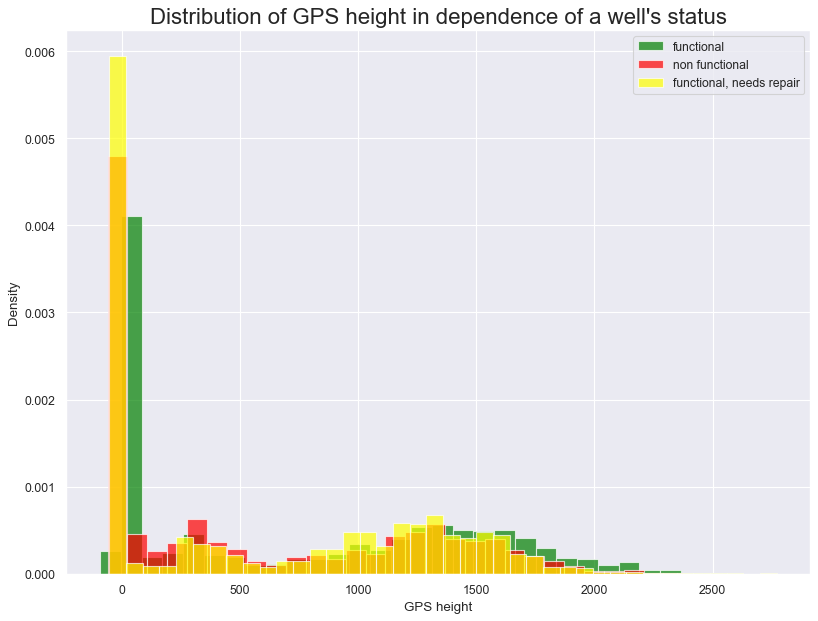

In [81]:
sns.set()
plt.figure(figsize=(12,9), dpi= 80)

sns.distplot(train.loc[train['status_group']=='functional', 'gps_height'], kde=False, norm_hist=True,
             color='green',hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, label="functional")
sns.distplot(train.loc[train['status_group']=='non functional', 'gps_height'], kde=False, norm_hist=True,
             color='red',hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, label="non functional")
sns.distplot(train.loc[train['status_group']=='functional needs repair', 'gps_height'], kde=False, norm_hist=True,
             color='yellow',hist_kws={'alpha':.7}, kde_kws={'linewidth':3}, label="functional, needs repair", bins=40)

plt.legend()
plt.xlabel('GPS height')
plt.ylabel('Density')
plt.title("Distribution of GPS height in dependence of a well's status", fontsize=20)

plt.show()

In [82]:
# overview of general distribution of the feature
train['gps_height'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [83]:
train[train['gps_height'] < 0]['status_group'].value_counts(normalize=True)

functional                 0.522727
non functional             0.449198
functional needs repair    0.028075
Name: status_group, dtype: float64

In [84]:
train[train['gps_height'] > 0]['status_group'].value_counts(normalize=True)

functional                 0.560722
non functional             0.372231
functional needs repair    0.067047
Name: status_group, dtype: float64

In [85]:
train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

**2. 'latitude' and 'longitude'**

We have already used the features 'latitude' and 'longitude' to obtain the coordinates of the wells.

Source of the map: https://data.humdata.org/dataset/tanzania-administrative-boundaries-level-1-to-3-regions-districts-and-wards-with-2012-population

In [86]:
# map of Tanzania
tanzania = gpd.read_file('zip://tanzania.zip')

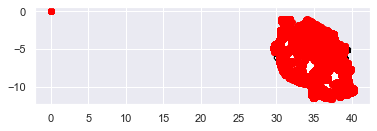

In [87]:
# plot map of Tanzania
ax = tanzania.plot(color='white', edgecolor='black')

# plot single observations on the map
train.plot(ax=ax, color='red')

plt.show()

There are outliers, which don't make sense (coordinates not in Tanzania).

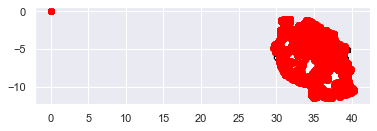

In [88]:
# plot map of Tanzania
ax = tanzania.plot(color='white', edgecolor='black')

# plot single observations on map
to_predict.plot(ax=ax, color='red')

plt.show()

The same goes for the data, we need to predict.
However, here we have the problem that we can't simply drop that observation.

In [89]:
train[train['longitude'] == 0]

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,geometry,status_group_numeric,month_recorded,waterpoint_age
21,6091,0.0,2013-02-10,DWSP,0,DWE,0.0,-2.000000e-08,Muungano,Lake Victoria,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional,POINT (0.00000 -0.00000),1.0,2,NaN
53,32376,0.0,2011-08-01,GOVERNMENT OF TANZANIA,0,GOVERNMENT,0.0,-2.000000e-08,Polisi,Lake Victoria,...,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,POINT (0.00000 -0.00000),0.0,8,NaN
168,72678,0.0,2013-01-30,WVT,0,WVT,0.0,-2.000000e-08,Wvt Tanzania,Lake Victoria,...,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,POINT (0.00000 -0.00000),1.0,1,NaN
177,56725,0.0,2013-01-17,NETHERLANDS,0,DWE,0.0,-2.000000e-08,Kikundi Cha Wakina Mama,Lake Victoria,...,shallow well,shallow well,groundwater,other,other,non functional,POINT (0.00000 -0.00000),0.0,1,NaN
253,13042,0.0,2012-10-29,HESAWA,0,DWE,0.0,-2.000000e-08,Kwakisusi,Lake Victoria,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,POINT (0.00000 -0.00000),0.5,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,0.0,2011-07-18,DWSP,0,DWE,0.0,-2.000000e-08,Wazazo,Lake Victoria,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,POINT (0.00000 -0.00000),0.5,7,NaN
59208,3631,0.0,2013-01-22,DWSP,0,DWE,0.0,-2.000000e-08,Mtakuja,Lake Victoria,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional,POINT (0.00000 -0.00000),1.0,1,NaN
59295,60843,0.0,2011-07-19,RWSSP,0,DWE,0.0,-2.000000e-08,Maendeleo,Lake Victoria,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional needs repair,POINT (0.00000 -0.00000),0.5,7,NaN
59324,748,0.0,2013-01-22,WORLD VISION,0,WORLD VISION,0.0,-2.000000e-08,Mwazwilo,Lake Victoria,...,shallow well,shallow well,groundwater,hand pump,hand pump,functional,POINT (0.00000 -0.00000),1.0,1,NaN


In [90]:
# possible feature to look for values to replace non-sense values
train[train['longitude'] == 0]['basin'].value_counts(normalize=True)

Lake Victoria      0.945364
Lake Tanganyika    0.054636
Name: basin, dtype: float64

In [91]:
train[train['basin'] == 'Lake Victoria']['longitude'].describe()

count    10248.000000
mean        27.284607
std         12.278315
min          0.000000
25%         30.864549
50%         32.686490
75%         33.584817
max         35.511809
Name: longitude, dtype: float64

In [92]:
train[train['basin'] == 'Lake Victoria']['latitude'].describe()

count    1.024800e+04
mean    -1.866879e+00
std      1.047662e+00
min     -3.933140e+00
25%     -2.689709e+00
50%     -1.911210e+00
75%     -1.343601e+00
max     -2.000000e-08
Name: latitude, dtype: float64

In [93]:
train[train['basin'] == 'Lake Victoria']['gps_height'].describe()

count    10248.000000
mean       328.424961
std        579.150378
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2056.000000
Name: gps_height, dtype: float64

In [94]:
train[train['basin'] == 'Lake Tanganyika']['longitude'].describe()

count    6432.000000
mean       30.730392
std         3.992779
min         0.000000
25%        30.201286
50%        30.949258
75%        32.244461
max        33.918313
Name: longitude, dtype: float64

I am going to replace the 0.0 values of 'longitude' with the median of the wells with the basin 'Lake Victoria' and the corresponding values of 'latitude' with the median as well.

In [95]:
# values for replacement
longi_median = train[train['basin'] == 'Lake Victoria']['longitude'].median()
lati_median = train[train['basin'] == 'Lake Victoria']['latitude'].median()

# latitude values of outliers we need to replace
lati_max = train[train['basin'] == 'Lake Victoria']['latitude'].max()

In [96]:
# replace values for longitude
train['longitude'].replace(0.0, longi_median, inplace = True)
to_predict['longitude'].replace(0.0, longi_median, inplace = True)

# replace values for latitude
train['latitude'].replace(lati_max, lati_median, inplace=True)
to_predict['latitude'].replace(lati_max, lati_median, inplace=True)

In [97]:
# update the geometry feature
train = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.longitude, train.latitude))
to_predict = gpd.GeoDataFrame(to_predict, geometry=gpd.points_from_xy(to_predict.longitude, to_predict.latitude))

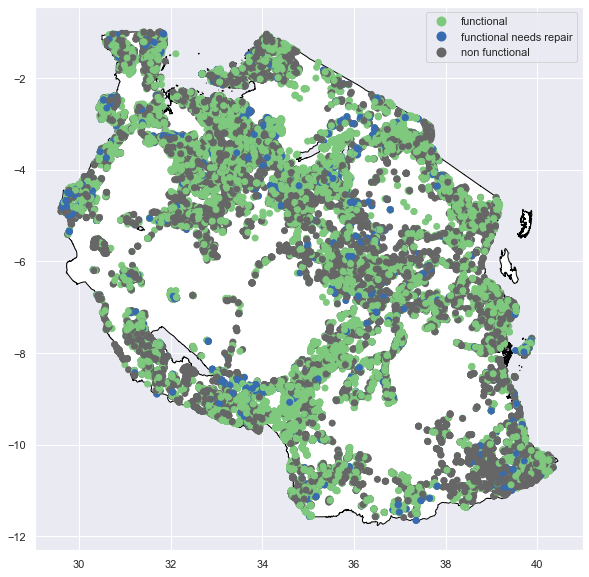

In [98]:
# plot map of Tanzania
ax = tanzania.plot(color='white', edgecolor='black', figsize=(10,10))

# plot single observations on map grouped by status
train.plot(ax=ax, column='status_group', cmap='Accent', legend=True)

plt.show()

A different plotting technique might be more useful to find out where functional, non functional and semi functional wells concentrate geographically.
I am going to plot three different heat maps for that (one for each status).

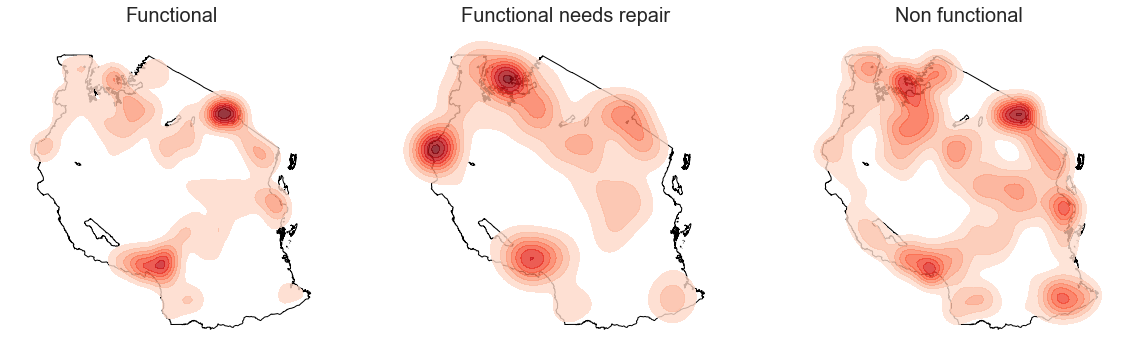

In [99]:
sns.set()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 10))

#plots
map1 = tanzania.plot(color='white', edgecolor='black', ax=ax1)
ax1.set_title('Functional', size=20)
geoplot.kdeplot(train[train['status_group'] == 'functional'], ax=map1, shade=True, cmap='Reds',
               shade_lowest=False, alpha=0.8)

map2 = tanzania.plot(color='white', edgecolor='black', ax=ax2)
ax2.set_title('Functional needs repair', size=20)
geoplot.kdeplot(train[train['status_group'] == 'functional needs repair'], ax=map2, shade=True,
               cmap='Reds', shade_lowest=False, alpha=0.8)

map3 = tanzania.plot(color='white', edgecolor='black', ax=ax3)
ax3.set_title('Non functional', size=20)
geoplot.kdeplot(train[train['status_group'] == 'non functional'], ax=map3, shade=True,
               cmap='Reds', shade_lowest=False, alpha=0.8)

plt.show()

We can see that the wells with different functionality stati concentrate in different geographic areas. Thus, these features should be very useful for our ML model.

## 2.6 Well and water features

In general there seem to be a lot of features which are kind of duplicate, e.g. 'source', 'source_type' and 'source_class'. Our main goal here is to first identify the necessary features only and then to explore their usability for our machine learning model.

### 2.6.1 Extraction

In [100]:
print(train['extraction_type'].unique())
print(len(train['extraction_type'].unique()))

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'ksb' 'mono' 'windmill' 'afridev' 'other - rope pump' 'india mark iii'
 'other - swn 81' 'other - play pump' 'cemo' 'climax' 'walimi'
 'other - mkulima/shinyanga']
18


In [101]:
print(train['extraction_type_group'].unique())
print(len(train['extraction_type_group'].unique()))

['gravity' 'submersible' 'swn 80' 'nira/tanira' 'india mark ii' 'other'
 'mono' 'wind-powered' 'afridev' 'rope pump' 'india mark iii'
 'other handpump' 'other motorpump']
13


In [102]:
print(train['extraction_type_class'].unique())
print(len(train['extraction_type_class'].unique()))

['gravity' 'submersible' 'handpump' 'other' 'motorpump' 'wind-powered'
 'rope pump']
7


In [103]:
train['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [104]:
train['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

I think the feature 'extraction_type_group' gives us the right trade-off between getting information which is as specific as possible and still being generalizable.

In [105]:
train.drop(['extraction_type', 'extraction_type_class'], axis=1, inplace=True)
to_predict.drop(['extraction_type', 'extraction_type_class'], axis=1, inplace=True)

In [106]:
train.groupby('extraction_type_group')['status_group_numeric'].mean()

extraction_type_group
afridev            0.689831
gravity            0.649683
india mark ii      0.619792
india mark iii     0.454082
mono               0.400175
nira/tanira        0.704133
other              0.176050
other handpump     0.500000
other motorpump    0.471311
rope pump          0.668514
submersible        0.559233
swn 80             0.598365
wind-powered       0.457265
Name: status_group_numeric, dtype: float64

In [107]:
pd.crosstab(train['extraction_type_group'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
extraction_type_group,,,
afridev,0.677966,0.023729,0.298305
gravity,0.599253,0.100859,0.299888
india mark ii,0.603333,0.032917,0.363750
india mark iii,0.448980,0.010204,0.540816
mono,0.377661,0.045026,0.577312
nira/tanira,0.664827,0.078612,0.256561
other,0.160031,0.032037,0.807932
other handpump,0.472527,0.054945,0.472527
other motorpump,0.434426,0.073770,0.491803


### 2.6.1 Quality

In [108]:
print(train['water_quality'].unique())
print(len(train['water_quality'].unique()))

['soft' 'salty' 'milky' 'unknown' 'fluoride' 'coloured' 'salty abandoned'
 'fluoride abandoned']
8


In [109]:
train['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [110]:
print(train['quality_group'].unique())
print(len(train['quality_group'].unique()))

['good' 'salty' 'milky' 'unknown' 'fluoride' 'colored']
6


In [111]:
train['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [112]:
# drop column 'water_quality'
train.drop(['water_quality'], axis=1, inplace=True)
to_predict.drop(['water_quality'], axis=1, inplace=True)

In [113]:
train.groupby('quality_group')['status_group_numeric'].mean()

quality_group
colored     0.557143
fluoride    0.753456
good        0.604353
milky       0.553483
salty       0.489413
unknown     0.150053
Name: status_group_numeric, dtype: float64

In [114]:
pd.crosstab(train['quality_group'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
quality_group,,,
colored,0.502041,0.110204,0.387755
fluoride,0.723502,0.059908,0.216590
good,0.565941,0.076823,0.357236
milky,0.544776,0.017413,0.437811
salty,0.460828,0.057170,0.482002
unknown,0.140725,0.018657,0.840618


### 2.6.2 Quantity

In [115]:
print(train['quantity'].unique())
print(len(train['quantity'].unique()))

['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5


In [116]:
print(train['quantity_group'].unique())
print(len(train['quantity_group'].unique()))

['enough' 'insufficient' 'dry' 'seasonal' 'unknown']
5


In [117]:
# drop column 'quantity'
train.drop(['quantity'], axis=1, inplace=True)
to_predict.drop(['quantity'], axis=1, inplace=True)

In [118]:
train.groupby('quantity_group')['status_group_numeric'].mean()

quantity_group
dry             0.028098
enough          0.688483
insufficient    0.571155
seasonal        0.625432
unknown         0.278834
Name: status_group_numeric, dtype: float64

In [119]:
pd.crosstab(train['quantity_group'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
quantity_group,,,
dry,0.025136,0.005924,0.968940
enough,0.652323,0.072320,0.275357
insufficient,0.523234,0.095842,0.380924
seasonal,0.574074,0.102716,0.323210
unknown,0.269962,0.017744,0.712294


### 2.6.3 Source

In [120]:
print(train['source'].unique())
print(len(train['source'].unique()))

['spring' 'rainwater harvesting' 'dam' 'machine dbh' 'other'
 'shallow well' 'river' 'hand dtw' 'lake' 'unknown']
10


In [121]:
print(train['source_type'].unique())
print(len(train['source_type'].unique()))

['spring' 'rainwater harvesting' 'dam' 'borehole' 'other' 'shallow well'
 'river/lake']
7


In [122]:
print(train['source_class'].unique())
print(len(train['source_class'].unique()))

['groundwater' 'surface' 'unknown']
3


In [123]:
train['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [124]:
train['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [125]:
# drop other source columns
train.drop(['source_type', 'source_class'], axis=1, inplace=True)
to_predict.drop(['source_type', 'source_class'], axis=1, inplace=True)

In [126]:
train.groupby('source')['status_group_numeric'].mean()

source
dam                     0.403963
hand dtw                0.578375
lake                    0.219608
machine dbh             0.511738
other                   0.596698
rainwater harvesting    0.672331
river                   0.632074
shallow well            0.523211
spring                  0.659773
unknown                 0.515152
Name: status_group_numeric, dtype: float64

In [127]:
pd.crosstab(train['source'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
source,,,
dam,0.385671,0.036585,0.577744
hand dtw,0.568650,0.019451,0.411899
lake,0.211765,0.015686,0.772549
machine dbh,0.489571,0.044334,0.466095
other,0.594340,0.004717,0.400943
rainwater harvesting,0.603922,0.136819,0.259259
river,0.568560,0.127029,0.304411
shallow well,0.494769,0.056883,0.448348
spring,0.622290,0.074966,0.302744


### 2.6.4 Waterpoint

In [128]:
print(train['waterpoint_type'].unique())
print(len(train['waterpoint_type'].unique()))

['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
7


In [129]:
print(train['waterpoint_type_group'].unique())
print(len(train['waterpoint_type_group'].unique()))

['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']
6


In [130]:
train['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [131]:
print(train['wpt_name'].unique())
print(len(train['wpt_name'].unique()))

['none' 'Zahanati' 'Kwa Mahundi' ... 'Kwa Yahona Kuvala' 'Mshoro'
 'Kwa Mzee Lugawa']
37400


In [132]:
train.groupby('waterpoint_type')['status_group_numeric'].mean()

waterpoint_type
cattle trough                  0.732759
communal standpipe             0.661104
communal standpipe multiple    0.419302
dam                            0.857143
hand pump                      0.647272
improved spring                0.772321
other                          0.154624
Name: status_group_numeric, dtype: float64

In [133]:
pd.crosstab(train['waterpoint_type'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
waterpoint_type,,,
cattle trough,0.724138,0.017241,0.258621
communal standpipe,0.621485,0.079237,0.299278
communal standpipe multiple,0.366213,0.106177,0.527609
dam,0.857143,0.000000,0.142857
hand pump,0.617852,0.058840,0.323307
improved spring,0.718112,0.108418,0.173469
other,0.131661,0.045925,0.822414


The value 'communal standpipe multiple' matters in terms of its quantity and its effect on the wells' condition.
Because of that I am going to drop the columns 'waterpoint_type_group' since it is redundant.

In contrast I am going to keep 'wpt_name', because it does not give us the same information

In [134]:
# drop column 'waterpoint_type_group'
train.drop(['waterpoint_type_group'], axis=1, inplace=True)
to_predict.drop(['waterpoint_type_group'], axis=1, inplace=True)

### 2.6.5 Basin

In [135]:
print(train['basin'].unique())
print(len(train['basin'].unique()))

['Lake Nyasa' 'Lake Victoria' 'Pangani' 'Ruvuma / Southern Coast'
 'Internal' 'Lake Tanganyika' 'Wami / Ruvu' 'Rufiji' 'Lake Rukwa']
9


In [136]:
train['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [137]:
train.groupby('basin')['status_group_numeric'].mean()

basin
Internal                   0.611496
Lake Nyasa                 0.678269
Lake Rukwa                 0.462510
Lake Tanganyika            0.540734
Lake Victoria              0.545911
Pangani                    0.627573
Rufiji                     0.662801
Ruvuma / Southern Coast    0.407968
Wami / Ruvu                0.546267
Name: status_group_numeric, dtype: float64

In [138]:
pd.crosstab(train['basin'], train['status_group'], normalize='index')

status_group,functional,functional needs repair,non functional
basin,,,
Internal,0.575723,0.071548,0.352730
Lake Nyasa,0.653687,0.049164,0.297148
Lake Rukwa,0.407498,0.110024,0.482478
Lake Tanganyika,0.483053,0.115361,0.401586
Lake Victoria,0.497658,0.096507,0.405835
Pangani,0.600895,0.053356,0.345749
Rufiji,0.635406,0.054789,0.309804
Ruvuma / Southern Coast,0.371689,0.072557,0.555753
Wami / Ruvu,0.523802,0.044931,0.431268


### 2.6.6 Total static head

In [139]:
train.groupby('status_group')['amount_tsh'].describe()

,count,mean,std,min,25%,50%,75%,max
status_group,,,,,,,,
functional,32259.0,461.798235,3889.735284,0.0,0.0,0.0,50.0,350000.0
functional needs repair,4317.0,267.071577,1925.026420,0.0,0.0,0.0,50.0,100000.0
non functional,22824.0,123.481230,1110.120571,0.0,0.0,0.0,0.0,117000.0


In [140]:
train['amount_tsh'].describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [141]:
print(len(train[train['amount_tsh'] == 0]))
print(len(train))

41639
59400


# 3. Data cleansing: missing values

To handle missing values I am first going to concatenate the two dataframes (training data and data I need to predict) such that the methods for filling missing values work consistently.

In [142]:
# include columns of target variable
to_predict['status_group'] = np.nan
to_predict['status_group_numeric'] =  np.nan

# make sure the order of the columns of the two dataframes are the same
to_predict = to_predict[list(train.columns)]

In [143]:
# to remember where to split the dataframe later on again
train.tail(1)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,payment_type,quality_group,quantity_group,source,waterpoint_type,status_group,geometry,status_group_numeric,month_recorded,waterpoint_age
59399,26348,0.0,2011-03-23,WORLD BANK,191,WORLD,38.104048,-6.747464,Kwa Mzee Lugawa,Wami / Ruvu,...,on failure,salty,enough,shallow well,hand pump,functional,POINT (38.10405 -6.74746),1.0,3,18.0


In [144]:
# concatenate dataframes
train = pd.concat([train, to_predict], ignore_index=True)

In [145]:
train.tail(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,basin,...,payment_type,quality_group,quantity_group,source,waterpoint_type,status_group,geometry,status_group_numeric,month_recorded,waterpoint_age
74247,28749,0.0,2013-03-04,NaN,1476,NaN,34.739804,-4.585587,Bwawani,Internal,...,never pay,good,insufficient,dam,communal standpipe,NaN,POINT (34.73980 -4.58559),NaN,3,10.0
74248,33492,0.0,2013-02-18,GERMANY,998,DWE,35.432732,-10.584159,Kwa John,Lake Nyasa,...,never pay,good,insufficient,river,communal standpipe,NaN,POINT (35.43273 -10.58416),NaN,2,11.0
74249,68707,0.0,2013-02-13,GOVERNMENT OF TANZANIA,481,GOVERNMENT,34.765054,-11.226012,Kwa Mzee Chagala,Lake Nyasa,...,never pay,good,dry,spring,communal standpipe,NaN,POINT (34.76505 -11.22601),NaN,2,12.0


In [146]:
train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 32 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null datetime64[ns]
funder                   69746 non-null object
gps_height               74250 non-null int64
installer                69718 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
basin                    74250 non-null object
subvillage               73780 non-null object
region_code              74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           70095 non-null float64
scheme_name              38992 non-null object
permit                   70457 non-null float64
construction_year        482

### 3.1 'public_meeting'

In [147]:
train.groupby('public_meeting')['status_group_numeric'].mean()

public_meeting
0.0    0.473591
1.0    0.593352
Name: status_group_numeric, dtype: float64

In [148]:
# exploratory analysis on the role of missing features in 'public_meeting'
train[train['public_meeting'].isnull()]['status_group_numeric'].mean()

0.5266946610677864

In our exploratory analysis on 'public_meeting' we could see the "means" of status_group for observations where 'public_meeting' is true or not.
The mean of the observations with missing values for 'public_meeting' is closer to the mean where there are no public meetings.
Because of that I am going to replace the missing values with 0s.

In [149]:
# impute missing values
train['public_meeting'].fillna(0, inplace=True)

### 3.2 'permit'

In [150]:
train.groupby('permit')['status_group_numeric'].mean()

permit
0.0    0.554825
1.0    0.589146
Name: status_group_numeric, dtype: float64

In [151]:
train[train['permit'].isnull()]['status_group_numeric'].mean()

0.5965314136125655

If we proceeded like in 3.1 we would now impute the missing values with 1s.
However there are two issuses with this approach here:
1. The difference between permitted and non permitted wells is not that great.
2. From a practical point of view it is not reasonable to assume that those wells are officially permitted when there are missing values.

As a trade-off between what the data tells us (choose 1) and what makes sense from a practical point of view (choose 0) I am going to impute the missing values using the groupby method with the mode.

In [152]:
# 'region_code': first feature for grouping
train.groupby('region_code')['permit'].mean()

region_code
1     0.450162
2     0.900570
3     0.897446
4     0.537361
5     0.989565
6     0.669783
7     0.000000
8     0.064000
9     0.813627
10    0.682410
11    0.601211
12    0.601416
13    0.719941
14    0.676447
15    0.645406
16    0.584772
17    0.469214
18    0.755678
19    0.975418
20    0.630303
21    0.948783
24    1.000000
40    0.000000
60    0.444530
80    0.650391
90    0.641659
99    0.986328
Name: permit, dtype: float64

In [153]:
# 'management_group': second feature for grouping
train.groupby('management_group')['permit'].mean()

management_group
commercial    0.718729
other         0.777675
parastatal    0.590343
unknown       0.668254
user-group    0.689742
Name: permit, dtype: float64

The two features 'region_code' and 'management_group' are good ones to apply the groupby method on since they give us reasonbale insights on the one hand but do not have too many values to use groupby with mode.

In [154]:
# impute missing values using groups and mode
train['permit'] = train.groupby(['region_code', 'management_group'])['permit'].apply(lambda x: x.fillna(x.mode()[0]))

In [155]:
train.groupby('permit')['status_group_numeric'].mean()
# only sligth changes in the distribution

permit
0.0    0.555183
1.0    0.589613
Name: status_group_numeric, dtype: float64

### 3.3 'waterpoint_age' / 'construction_year'

In [156]:
train.groupby('extraction_type_group')['waterpoint_age'].mean().round(0)

extraction_type_group
afridev            18.0
gravity            24.0
india mark ii      19.0
india mark iii     16.0
mono               27.0
nira/tanira        20.0
other              27.0
other handpump     19.0
other motorpump     9.0
rope pump          14.0
submersible        21.0
swn 80             23.0
wind-powered       24.0
Name: waterpoint_age, dtype: float64

The feature 'extraction_type_group' is very good to use groupby on and calculate the mean age because it refers to different kinds of technologies.
Technologies and innovations are always correlated with temporal aspects and to the age respectively.

In [157]:
# impute missing values for age
train['waterpoint_age'] = train['waterpoint_age'].fillna(train.groupby('extraction_type_group')['waterpoint_age'].transform('mean').round(0))

# impute values for construction year
train['construction_year'] = train['construction_year'].fillna(current_year - train['waterpoint_age'])

### 3.4 'funder' and 'installer'

For the features 'funder' and 'installer' I am going to use the groupby method on 'region_code' and 'permit' and use the mode of the respective feature.
This is by far not the best solution but one of the few ones which is computationally feasible and still makes some sense.

In [158]:
train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage',
       'region_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_name', 'permit', 'construction_year', 'extraction_type_group',
       'management', 'management_group', 'payment_type', 'quality_group',
       'quantity_group', 'source', 'waterpoint_type', 'status_group',
       'geometry', 'status_group_numeric', 'month_recorded', 'waterpoint_age'],
      dtype='object')

In [159]:
# impute missing values for 'funder'
train['funder'] = train.groupby(['region_code', 'permit'])['funder'].apply(lambda x: x.fillna(x.mode()[0]))

# impute missing values for 'installer'
train['installer'] = train.groupby(['region_code', 'permit'])['installer'].apply(lambda x: x.fillna(x.mode()[0]))

### 3.5 'subvillage' and 'scheme_name'

There are also missing values in 'subvillage' and 'scheme_name'.
However I am not going to deal with these for the following reasons:

1. In 'scheme_name' there are simply to many different categorical values and too many missing values. So an imputation of the missing values would be quite hard. Also I am not going to use this feature for the ML model.
2. Almost the same goes for 'subvillage'. The only difference here is that there are not many missing values at all.

In [160]:
train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 32 columns):
id                       74250 non-null int64
amount_tsh               74250 non-null float64
date_recorded            74250 non-null datetime64[ns]
funder                   74250 non-null object
gps_height               74250 non-null int64
installer                74250 non-null object
longitude                74250 non-null float64
latitude                 74250 non-null float64
wpt_name                 74250 non-null object
basin                    74250 non-null object
subvillage               73780 non-null object
region_code              74250 non-null int64
lga                      74250 non-null object
ward                     74250 non-null object
population               74250 non-null int64
public_meeting           74250 non-null float64
scheme_name              38992 non-null object
permit                   74250 non-null float64
construction_year        742

# 4. Feature engineering

In section 2 I already performed EDA and explained which features I consider to be relevant.
For the categorical features I am now going to calculate indices ranging from 0 to 1 indicating the average quality of the wells with the corresponding values for that feature.

### 4.1 Installer

In [161]:
# calculate installer_index
df_installer = pd.DataFrame(train.groupby('installer')['status_group_numeric'].mean().reset_index())
df_installer.rename(columns={'status_group_numeric': 'installer_index'}, inplace=True)

In [162]:
# quick look at the dataframe
df_installer.head(3)

,installer,installer_index
0,-,0.666667
1,0,0.574534
2,A.D.B,0.500000


In [163]:
# merge installer_index on data
train = train.merge(df_installer, how='left', on='installer')

### 4.2 Basin

In [164]:
# calculate basin index
df_basin = pd.DataFrame(train.groupby('basin')['status_group_numeric'].mean().reset_index())
df_basin.rename(columns={'status_group_numeric': 'basin_index'}, inplace=True)

In [165]:
# quick look 
df_basin.head(3)

,basin,basin_index
0,Internal,0.611496
1,Lake Nyasa,0.678269
2,Lake Rukwa,0.462510


In [166]:
# merge basin_index on data
train = train.merge(df_basin, how='left', on='basin')

### 4.3 region_code

In [167]:
# calculate region index
df_region = pd.DataFrame(train.groupby('region_code')['status_group_numeric'].mean().reset_index())
df_region.rename(columns={'status_group_numeric': 'region_index'}, inplace=True)

In [168]:
# quick look 
df_region.head(3)

,region_code,region_index
0,1,0.505906
1,2,0.682870
2,3,0.639644


In [169]:
# merge region_index on data
train = train.merge(df_region, how='left', on='region_code')

### 4.4 extraction_type_group

In [170]:
# calculate extraction index
df_extract = pd.DataFrame(train.groupby('extraction_type_group')['status_group_numeric'].mean().reset_index())
df_extract.rename(columns={'status_group_numeric': 'extraction_index'}, inplace=True)

In [171]:
# quick look 
df_extract.head(3)

,extraction_type_group,extraction_index
0,afridev,0.689831
1,gravity,0.649683
2,india mark ii,0.619792


In [172]:
# merge extraction_index on data
train = train.merge(df_extract, how='left', on='extraction_type_group')

### 4.5 Management

In [173]:
# calculate management index
df_management = pd.DataFrame(train.groupby('management')['status_group_numeric'].mean().reset_index())
df_management.rename(columns={'status_group_numeric': 'management_index'}, inplace=True)

In [174]:
# quick look 
df_management.head(3)

,management,management_index
0,company,0.400730
1,other,0.630924
2,other - school,0.237374


In [175]:
# merge extraction_index on data
train = train.merge(df_management, how='left', on='management')

### 4.6 Payment

In [176]:
# calculate payment index
df_payment = pd.DataFrame(train.groupby('payment_type')['status_group_numeric'].mean().reset_index())
df_payment.rename(columns={'status_group_numeric': 'payment_index'}, inplace=True)

In [177]:
# quick look 
df_payment.head(3)

,payment_type,payment_index
0,annually,0.786244
1,monthly,0.716325
2,never pay,0.486528


In [178]:
# merge payment_index on data
train = train.merge(df_payment, how='left', on='payment_type')

### 4.7 Quality

In [179]:
# calculate quality (water) index
df_quality = pd.DataFrame(train.groupby('quality_group')['status_group_numeric'].mean().reset_index())
df_quality.rename(columns={'status_group_numeric': 'quality_index'}, inplace=True)

In [180]:
# quick look 
df_quality.head(3)

,quality_group,quality_index
0,colored,0.557143
1,fluoride,0.753456
2,good,0.604353


In [181]:
# merge quality_index on data
train = train.merge(df_quality, how='left', on='quality_group')

### 4.8 Quantity

In [182]:
# calculate quantity (water) index
df_quantity = pd.DataFrame(train.groupby('quantity_group')['status_group_numeric'].mean().reset_index())
df_quantity.rename(columns={'status_group_numeric': 'quantity_index'}, inplace=True)

In [183]:
# quick look 
df_quantity.head(3)

,quantity_group,quantity_index
0,dry,0.028098
1,enough,0.688483
2,insufficient,0.571155


In [184]:
# merge quantity_index on data
train = train.merge(df_quantity, how='left', on='quantity_group')

### 4.9 Source

In [185]:
# calculate source index
df_source = pd.DataFrame(train.groupby('source')['status_group_numeric'].mean().reset_index())
df_source.rename(columns={'status_group_numeric': 'source_index'}, inplace=True)

In [186]:
# quick look 
df_source.head(3)

,source,source_index
0,dam,0.403963
1,hand dtw,0.578375
2,lake,0.219608


In [187]:
# merge source_index on data
train = train.merge(df_source, how='left', on='source')

### 4.10 Waterpoint type

In [188]:
# calculate wpt type index
df_wpt_type = pd.DataFrame(train.groupby('waterpoint_type')['status_group_numeric'].mean().reset_index())
df_wpt_type.rename(columns={'status_group_numeric': 'wpt_type_index'}, inplace=True)

In [189]:
# quick look 
df_wpt_type.head(3)

,waterpoint_type,wpt_type_index
0,cattle trough,0.732759
1,communal standpipe,0.661104
2,communal standpipe multiple,0.419302


In [190]:
# merge wpt_type_index on data
train = train.merge(df_wpt_type, how='left', on='waterpoint_type')

# 5. Machine Learning model

I am going to fit a (simple) random forest model on the data.

I think that a random forest model is a good choice here for the following reasons:

1. We have three different but ordinal target values. Compared to other models like (multinomial) logistic regression or a naive Bayes classifier I think that random forest can handle this situation the best.

2. Random forest is computationally feasible. k-Nearest Neighbors might actually make good predictions, too, from a methodological point of view. However, that algorithm is too slow. Random forest runs much faster.

3. Especially for the spatial features (longitude, latitude, gps_height) which are very important as we have seen in our EDA random forest is well suited to capture these non-linear dependicies.

## 5.1 Packages

In [191]:
# random forests classifier
from sklearn.ensemble import RandomForestClassifier

In [192]:
# evaluation metric
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [221]:
# model testing and tuning
from sklearn.model_selection import train_test_split

# cross validation techniques
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

## 5.2 Adjustments on data for training the model

We need to make some further adjustments before we are able to train our model on the data.

In [194]:
# split the training and evaluation data again
train_1 = train.iloc[:59400, :]
test_1 = train.iloc[59400:, :]

In [ ]:
test_1.info()

As I have found out the imputation for the feature 'installer' / 'installer_index' in the third chapter was not sufficient for the test data since there are new values for some features which have beent directly or indirectly relevant.
I am going to use a simple imputation method for those few missing values.

In [257]:
test_1['installer_index'] = test_1['installer_index'].fillna(test_1.groupby('management')['installer_index'].transform('mean'))

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## 5.3 Models

### 5.3.1 First initial model

In [195]:
# identify features needed for the model
train_1.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'basin', 'subvillage',
       'region_code', 'lga', 'ward', 'population', 'public_meeting',
       'scheme_name', 'permit', 'construction_year', 'extraction_type_group',
       'management', 'management_group', 'payment_type', 'quality_group',
       'quantity_group', 'source', 'waterpoint_type', 'status_group',
       'geometry', 'status_group_numeric', 'month_recorded', 'waterpoint_age',
       'installer_index', 'basin_index', 'region_index', 'extraction_index',
       'management_index', 'payment_index', 'quality_index', 'quantity_index',
       'source_index', 'wpt_type_index'],
      dtype='object')

Extract numpy arrays from the pandas dataframe (train data).

In [196]:
# features
X = train_1[['gps_height', 'longitude', 'latitude', 'region_index', #geographic features
            'waterpoint_age', #time features
            'installer_index', 'management_index', 'payment_index', #management features
            'amount_tsh', 'extraction_index', 'quality_index', 'quantity_index',
            'source_index', 'wpt_type_index', 'basin_index', #well and water features
            'population', 'public_meeting', 'permit']].values #demographic / economic features

# labels
y = train_1[['status_group']].values

Split data into train (0.7) and test (0.3) data

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

Train first model without customized settings on hyperparameters.

In [198]:
# instantiate random forests classifier (default settings)
rf = RandomForestClassifier(random_state=1)

In [199]:
# fir rf with default settings
rf.fit(X_train, y_train)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [200]:
# make predictions on test data
y_pred = rf.predict(X_test)

In [201]:
# prediction quality
accuracy_score(y_test, y_pred)

0.8037037037037037

In [202]:
# more detailed look where the model tends to fail
confusion_matrix(y_test, y_pred, labels=['functional', 'functional needs repair', 'non functional'])

array([[8638,  293,  760],
       [ 654,  419,  197],
       [1454,  140, 5265]], dtype=int64)

Furhtermore it might be interesting / useful to see which features are rather important for our random forests model.

In [203]:
features = ['gps_height', 'longitude', 'latitude', 'region_index', #geographic features
            'waterpoint_age', #time features
            'installer_index', 'management_index', 'payment_index', #management features
            'amount_tsh', 'extraction_index', 'quality_index', 'quantity_index',
            'source_index', 'wpt_type_index', 'basin_index', #well and water features
            'population', 'public_meeting', 'permit']

In [204]:
rf.feature_importances_

array([0.06867445, 0.14709399, 0.14535424, 0.02414271, 0.05778764,
       0.10826291, 0.02077842, 0.03477057, 0.0223233 , 0.05678575,
       0.01325311, 0.13225567, 0.03221233, 0.05198587, 0.01819758,
       0.04867129, 0.00877082, 0.00867935])

In [205]:
for name, importance in zip(features, rf.feature_importances_):
    print(name, '=', importance)

gps_height = 0.06867444576685779
longitude = 0.1470939876011916
latitude = 0.14535423545441034
region_index = 0.024142711901623228
waterpoint_age = 0.057787642449257284
installer_index = 0.1082629131873899
management_index = 0.020778423480395797
payment_index = 0.03477057121306964
amount_tsh = 0.022323302172240943
extraction_index = 0.05678574871155999
quality_index = 0.013253110410853617
quantity_index = 0.1322556724061168
source_index = 0.03221232736792451
wpt_type_index = 0.05198586735217083
basin_index = 0.018197576196377057
population = 0.048671289485053934
public_meeting = 0.008770824713062085
permit = 0.008679350130444628


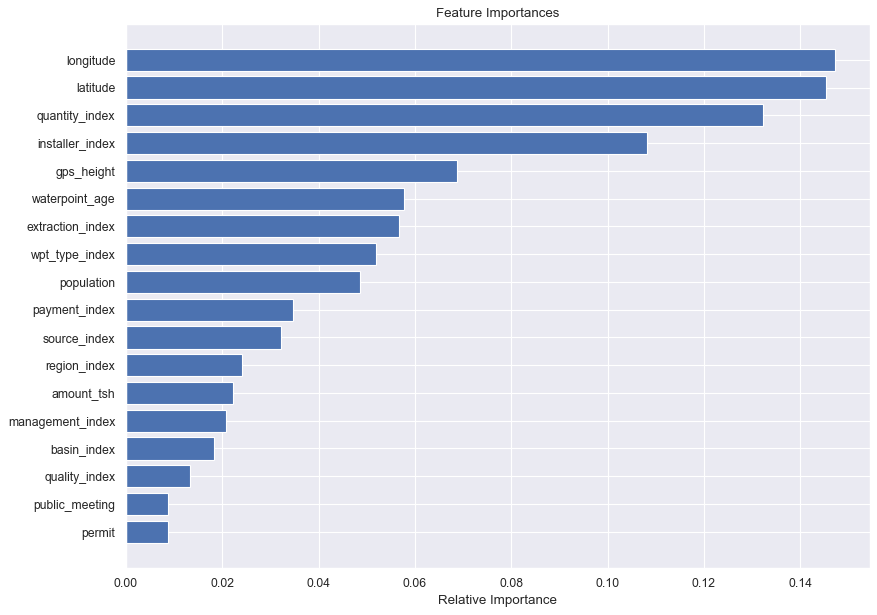

In [206]:
# features = features
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,9), dpi= 80)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [207]:
train_labels['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

### 5.3.2 Hyperparameter tuning

Hyperparameter tuning is a good (if computationally expensive) way to make some final slight improvements for our model.
To find out how we can optimize our model doing that we first need to know, which hyperparameters we are working with:

In [208]:
# inspect rf's hyperparameters
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

Instantiate a parameter grid for the first (randomized) grid search.

In [217]:
params_rf = {'criterion': ['gini', 'entropy'],
            'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 11)],
            'max_features': ['auto', 'sqrt'],
            'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]}

In [218]:
params_rf

{'criterion': ['gini', 'entropy'],
 'n_estimators': [100, 290, 480, 670, 860, 1050, 1240, 1430, 1620, 1810, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

At first I am going to apply a randomized grid search because it is computationally very expensive.
That shall give me a first insight for which value ranges the hyperparameters are chosen best.

In [222]:
rf_random = RandomizedSearchCV(estimator=rf,
                              param_distributions=params_rf,
                              n_iter=100, cv=3,
                              verbose=2, random_state=42,
                              n_jobs=-1)

In [223]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 73.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 136.3min finished
C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=10,
                                                    n_jobs=None,
  

In [225]:
# Extract best model from 'rf_random' 
best_model = rf_random.best_estimator_

In [224]:
# Extract hyperparameters from the best model
rf_random.best_params_

{'n_estimators': 1620,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 20,
 'criterion': 'entropy',
 'bootstrap': False}

In [226]:
# accuracy score of our best model
y_pred = best_model.predict(X_test)
accuracy_score(y_test, y_pred)

In [227]:
accuracy_score(y_test, y_pred)

0.8154882154882155

Try out minor changes in the hyperparameter settings and investigate its effect

In [228]:
# change bootstrap to True
rf_new = RandomForestClassifier(n_estimators=1620, min_samples_split=10,
                               min_samples_leaf=2, max_features='auto',
                               max_depth=20, criterion='entropy',
                               bootstrap=True)

In [229]:
rf_new.fit(X_train, y_train)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1620,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [231]:
y_pred = rf_new.predict(X_test)
accuracy_score(y_test, y_pred)

In [232]:
accuracy_score(y_test, y_pred)

0.8124579124579124

No improvement; keep bootstrap set to False

Try if changing the criterion to 'gini' has a positive impact

In [235]:
rf_new = RandomForestClassifier(n_estimators=1620, min_samples_split=10,
                               min_samples_leaf=2, max_features='auto',
                               max_depth=20, criterion='gini',
                               bootstrap=False)

In [236]:
rf_new.fit(X_train, y_train)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1620,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [237]:
y_pred = rf_new.predict(X_test)
accuracy_score(y_test, y_pred)

In [238]:
accuracy_score(y_test, y_pred)

0.8161054994388328

Using the gini-criterion gives us slight better results.

In [240]:
rf_improved = RandomForestClassifier(bootstrap=False,
                                    criterion='gini',
                                    random_state=1,
                                    max_features='auto',
                                    min_samples_leaf=2,
                                    min_samples_split=10,
                                    max_depth=20)

Furthermore we can have another look at which values for 'n_estimators' might be better. This time I am going to use graphical techniques to find that out.

In [241]:
# different options for n_estimators 
n_estimators = [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]

# lists to store the results for different numbers of trees
train_results_n = []
test_results_n = []


# loop over the different numbers of trees
for estimator in n_estimators:

   # fit the model 
   rf = RandomForestClassifier(bootstrap=False,
                               criterion='gini',
                               random_state=1,
                               max_features='auto',
                               min_samples_leaf=2,
                               min_samples_split=10,
                               max_depth=20,
                               n_jobs=-1)
   rf.fit(X_train, y_train)

   # evaluate on training set and store the results
   y_train_pred = rf.predict(X_train)
   train_acc = accuracy_score(y_train, y_train_pred)
   train_results_n.append(train_acc)

   # evaluate on test set and store the results
   y_test_pred = rf.predict(X_test)
   pred_acc = accuracy_score(y_test, y_test_pred)
   test_results_n.append(pred_acc)

C:\Users\david\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\david\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\david\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: 

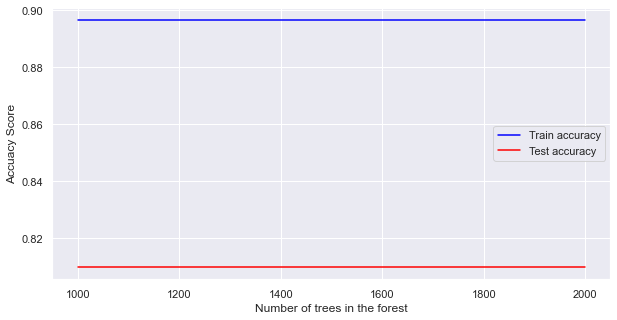

In [242]:
# turn lists into numpy arrays
n_estimators = np.array(n_estimators)
train_results_n = np.array(train_results_n)
test_results_n = np.array(test_results_n)

# plot
fig, ax = plt.subplots(figsize=(10, 5))

plt.plot(n_estimators, train_results_n, color='blue', label='Train accuracy')
plt.plot(n_estimators, test_results_n, color='red', label='Test accuracy')

plt.grid(True)
plt.xlabel('Number of trees in the forest')
plt.ylabel('Accuacy Score')
plt.legend()

plt.show()

The differences are very small and barely visible in the plot.

I am simply going to go with the higher value for 'n_estimators'.

In [244]:
rf_improved = RandomForestClassifier(bootstrap=False,
                                    criterion='gini',
                                    random_state=1,
                                    max_features='auto',
                                    min_samples_leaf=2,
                                    min_samples_split=10,
                                    max_depth=20,
                                    n_estimators=2000,
                                    n_jobs=-1)

In [245]:
rf_improved.fit(X_train, y_train)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [246]:
y_pred = rf_improved.predict(X_test)

In [247]:
accuracy_score(y_test, y_pred)

0.8163860830527497

### 5.3.3 Final model and predictions

With the slight improvements we have made with the hyperparameter tuning we can now fit a model based on the entire data.

In [248]:
rf_improved.fit(X, y)

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [249]:
# predictions quality on entire training data
y_pred = rf_improved.predict(X)
accuracy_score(y, y_pred)

0.9014814814814814

#### Predictions

In [262]:
# features
X_to_pred = test_1[['gps_height', 'longitude', 'latitude', 'region_index', #geographic features
            'waterpoint_age', #time features
            'installer_index', 'management_index', 'payment_index', #management features
            'amount_tsh', 'extraction_index', 'quality_index', 'quantity_index',
            'source_index', 'wpt_type_index', 'basin_index', #well and water features
            'population', 'public_meeting', 'permit']].values #demographic / economic features

Now we can make the predictions

In [263]:
y_submission = rf_improved.predict(X_to_pred)

In [264]:
# check out the required submission format again
submission_format.head(3)

,id,status_group
0,50785,predicted label
1,51630,predicted label
2,17168,predicted label


In [266]:
# write a pandas dataframe with the predictions and the fitting submission format
prediction_file = pd.DataFrame({'id': test_1['id'], 'status_group': y_submission})

In [267]:
prediction_file.head()

,id,status_group
59400,50785,functional
59401,51630,functional
59402,17168,functional
59403,45559,non functional
59404,49871,functional


In [268]:
# writing the csv file
prediction_file.to_csv('pump_it_up_prediction.csv', index=False)